# 第4章 割引クーポンキャンペーンの効果最大化


## 課題整理

- 数理モデル決定事項
> **要件(1):各会員に対してどのパターンのダイレクトメールを送付するかを決定**

- 送付するダイレクトメールの数
> **要件(2):各会員に対して送付するダイレクトメールはいずれかの1パターン**

- キャンペーンの目的
> **要件(3):クーポン付与による来客増加数を最大化する**

- キャンペーン予算
> **要件(4):館員の予算消費期待値の合計は100万円以下**

- 次回以降のクーポンキャンペーンで利用する来客率の収集
> **要件(5):各パターンのダイレクトメールをそれぞれのセグメントに属する会員の10%以上に送付**

## 4.3 データ理解

### データの確認

（1） 会員データ（customers.csv）の確認

In [223]:
import pandas as pd
cust_df = pd.read_csv('customers.csv')
cust_df.shape

(5000, 3)

In [224]:
# ファイル上部のレコード
cust_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [225]:
# データの型
cust_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

<Axes: >

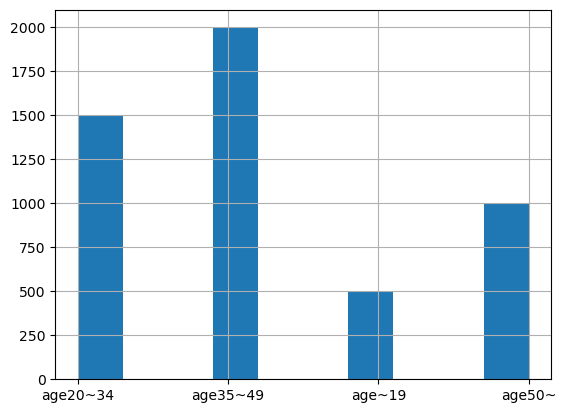

In [226]:
cust_df['age_cat'].hist()

<Axes: >

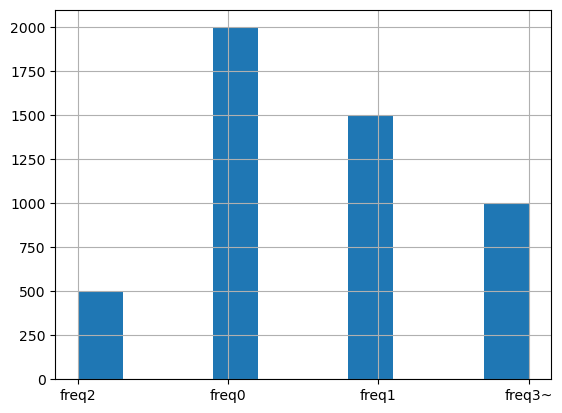

In [227]:
cust_df['freq_cat'].hist()

In [228]:
cust_pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
cust_pivot_df = cust_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<Axes: xlabel='freq_cat', ylabel='age_cat'>

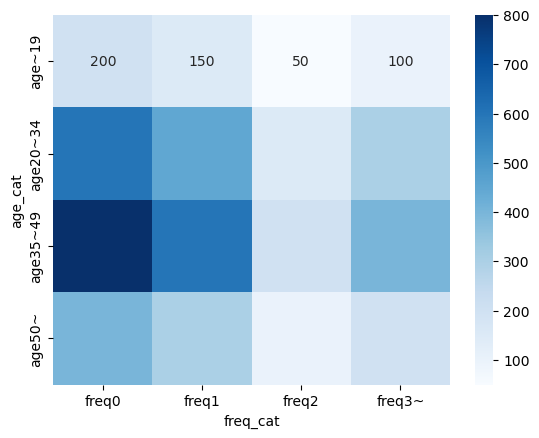

In [229]:
import seaborn as sns
sns.heatmap(cust_pivot_df, annot=True, fmt='d', cmap='Blues')

（2） 来店率データ（visit_probability.csv）の確認

In [230]:
prob_df = pd.read_csv('visit_probability.csv')
prob_df.shape

(16, 6)

In [231]:
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


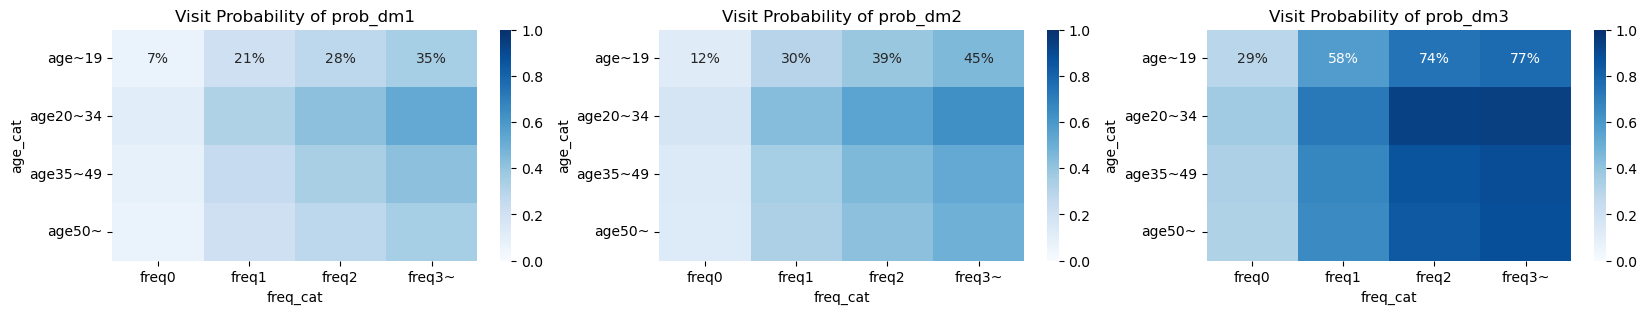

In [232]:
import matplotlib.pyplot as plt
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex (['age~19','age20~34', 'age35~49', 'age50~'])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

## 4.4 数理モデリングと実装

## 課題整理

- 数理モデル決定事項
> **要件(1):各会員に対してどのパターンのダイレクトメールを送付するかを決定**

- 送付するダイレクトメールの数
> **要件(2):各会員に対して送付するダイレクトメールはいずれかの1パターン**

- キャンペーンの目的
> **要件(3):クーポン付与による来客増加数を最大化する**

- キャンペーン予算
> **要件(4):館員の予算消費期待値の合計は100万円以下**

- 次回以降のクーポンキャンペーンで利用する来客率の収集
> **要件(5):各パターンのダイレクトメールをそれぞれのセグメントに属する会員の10%以上に送付**

### モデリング1：会員個別送付モデル

In [233]:
# !pip install pulp
import pulp

problem = pulp.LpProblem(name='DiscountCouponProblem1',sense=pulp.LpMaximize)

要件（1） 各会員に対してどのパターンのダイレクトメールを送付するかを決定

- リスト
  - 会員のリスト：$I$
  - ダイレクトメールのパターンのリスト：$M$(={1,2,3})
    - 1:セールのチラシのみ
    - 2:セールチラシと1000円クーポン
    - 3:セールチラシと2000円クーポン
- 決定変数
  - 会員$i(\in I)$ に対してダイレクトメールのパターン$m(\in M)$ を送付する場合に1, しない場合に0を取る変数：$x_{i,m} \in (0,1)  (i \in I, m \in M)$

In [234]:
# 会員IDのリスト
I = cust_df['customer_id'].to_list()
len(I)

5000

In [235]:
# ダイレクトメールのパターンのリスト
M = [1, 2, 3]

In [236]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定
xim = {}
for i in I:
    for m in M:
        xim[i,m] = pulp.LpVariable(name=f'xim({i},{m})',cat='Binary')
# 決定変数の数
len(xim)

15000

要件（2） 各会員に対して送付するダイレクトメールはいずれか1 パターン
制約条件：各会員に対して送付するダイレクトメールはいずれか1 パターン
  - $\sum_{m \in M} x_{i,m} = 1  (i \in I)$

In [237]:
# （2）各会員に対して送付するダイレクトメールはいずれか1パターン
for i in I:
    problem += pulp.lpSum(xim[i,m] for m in M) == 1

要件（3） クーポン付与による来客増加数を最大化

- 定数
  - 会員$i$に対してパターン$m( \in M)$のダイレクトメールを送付した時の来店率:P_{im}
    - $P_{im} \in [0,1] (i \in I, m \in M)$

- 目的変数
  - クーポン付与による来客増加数を最大化：$\sum_{i \in I}\sum_{m \in M} (P_{im} - P_{i1})x_{im}$



In [238]:
keys = ['age_cat', 'freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,2,age35~49,freq0,9,0.08,0.14,0.33
2,3,age35~49,freq0,9,0.08,0.14,0.33
3,4,age~19,freq0,1,0.07,0.12,0.29
4,5,age35~49,freq0,9,0.08,0.14,0.33


In [239]:
cust_prob_ver_df = cust_prob_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})\
                  .melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
cust_prob_ver_df

,customer_id,dm,prob
0,1,1,0.42
1,2,1,0.08
2,3,1,0.08
3,4,1,0.07
4,5,1,0.08
...,...,...,...
14995,4996,3,0.32
14996,4997,3,0.32
14997,4998,3,0.67
14998,4999,3,0.65


In [240]:
Pim = cust_prob_ver_df.set_index(['customer_id','dm'])['prob'].to_dict()
print(Pim)

{(1, 1): 0.42, (2, 1): 0.08, (3, 1): 0.08, (4, 1): 0.07, (5, 1): 0.08, (6, 1): 0.32, (7, 1): 0.21, (8, 1): 0.07, (9, 1): 0.08, (10, 1): 0.32, (11, 1): 0.25, (12, 1): 0.25, (13, 1): 0.25, (14, 1): 0.34, (15, 1): 0.08, (16, 1): 0.32, (17, 1): 0.08, (18, 1): 0.07, (19, 1): 0.32, (20, 1): 0.21, (21, 1): 0.25, (22, 1): 0.32, (23, 1): 0.25, (24, 1): 0.25, (25, 1): 0.21, (26, 1): 0.08, (27, 1): 0.52, (28, 1): 0.35, (29, 1): 0.07, (30, 1): 0.11, (31, 1): 0.08, (32, 1): 0.07, (33, 1): 0.11, (34, 1): 0.07, (35, 1): 0.08, (36, 1): 0.52, (37, 1): 0.08, (38, 1): 0.52, (39, 1): 0.32, (40, 1): 0.11, (41, 1): 0.07, (42, 1): 0.08, (43, 1): 0.25, (44, 1): 0.32, (45, 1): 0.07, (46, 1): 0.52, (47, 1): 0.11, (48, 1): 0.21, (49, 1): 0.07, (50, 1): 0.21, (51, 1): 0.25, (52, 1): 0.25, (53, 1): 0.08, (54, 1): 0.25, (55, 1): 0.25, (56, 1): 0.08, (57, 1): 0.25, (58, 1): 0.08, (59, 1): 0.11, (60, 1): 0.08, (61, 1): 0.21, (62, 1): 0.11, (63, 1): 0.11, (64, 1): 0.08, (65, 1): 0.21, (66, 1): 0.32, (67, 1): 0.07, (68

In [241]:
Pim[1,1]

0.42

In [242]:
# （3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum((Pim[i,m] - Pim[i,1]) * xim[i,m] for i in I for m in [2,3])#クーポン無しの場合は、目的関数に影響を与えないため、パターン2,3[2,3]のみ考慮

要件（4） 会員の予算消費期待値の合計は100 万円以下

- 定数
  - ダイレクトメールのパターン$m( \in M)$に付与するクーポンの金額
    - $C_m \in {0, 1000, 2000} (m \in M)$

- 制約条件
  - 会員の予算消費期待値の合計は100 万円以下：$\sum_{i \in I}\sum_{m \in M} C_{m} P_{im} x_{im} \leq 1000000$

In [243]:
Cm = {1:0, 2:1000, 3:2000}

In [244]:
# （4）会員の消費する費用の期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Pim[i,m]* xim[i,m] for i in I for m in [2,3]) <= 1000000

要件（5） 各パターンのダイレクトメールをそれぞれのセグメントに属する会員10% 以上に送付

- リスト
  - 年齢区分、昨年度来店回数区分によるセグメントのリスト：$S$
  
- 定数
  - セグメント$s( \in S)$に属する会員数
    - $N_s \in N(非負整数) (s \in S)$
  - 会員$i( \in I)$がセグメント$s( \in S)$に属する場合に1、そうでない場合に0となる定数
    - $Z_{is} \in {0,1} (i \in I, s \in S)$

- 制約条件
  - 各パターンのダイレクトメールをそれぞれのセグメントに属する会員10% 以上に送付
    - $\sum_{i \in I} Z_{is} x_{im} \geq 0.1*N_s (s \in S, m \in M)$

In [245]:
# セグメントのリスト
S = prob_df['segment_id'].to_list()
len(S)

16

In [246]:
# 各セグメントとそのセグメントに属する会員数を対応させる辞書の作成
Ns = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(Ns)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [247]:
# 会員をキーとして属するセグメントを返す辞書
Si = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()
print(Si)

{1: 7, 2: 9, 3: 9, 4: 1, 5: 9, 6: 6, 7: 2, 8: 1, 9: 9, 10: 6, 11: 10, 12: 10, 13: 10, 14: 11, 15: 9, 16: 6, 17: 9, 18: 13, 19: 6, 20: 2, 21: 10, 22: 6, 23: 10, 24: 10, 25: 2, 26: 9, 27: 8, 28: 4, 29: 13, 30: 5, 31: 9, 32: 1, 33: 5, 34: 1, 35: 9, 36: 8, 37: 9, 38: 8, 39: 6, 40: 5, 41: 13, 42: 9, 43: 10, 44: 6, 45: 13, 46: 8, 47: 5, 48: 2, 49: 13, 50: 14, 51: 10, 52: 10, 53: 9, 54: 10, 55: 10, 56: 9, 57: 10, 58: 9, 59: 5, 60: 9, 61: 2, 62: 5, 63: 5, 64: 9, 65: 2, 66: 6, 67: 13, 68: 10, 69: 2, 70: 10, 71: 8, 72: 15, 73: 10, 74: 5, 75: 16, 76: 9, 77: 10, 78: 5, 79: 10, 80: 6, 81: 16, 82: 13, 83: 9, 84: 11, 85: 6, 86: 12, 87: 12, 88: 11, 89: 6, 90: 16, 91: 5, 92: 3, 93: 4, 94: 6, 95: 5, 96: 1, 97: 12, 98: 13, 99: 10, 100: 5, 101: 5, 102: 9, 103: 4, 104: 4, 105: 13, 106: 10, 107: 10, 108: 2, 109: 9, 110: 12, 111: 6, 112: 9, 113: 11, 114: 12, 115: 9, 116: 9, 117: 6, 118: 5, 119: 6, 120: 9, 121: 6, 122: 9, 123: 9, 124: 9, 125: 16, 126: 9, 127: 9, 128: 11, 129: 8, 130: 14, 131: 13, 132: 10, 133

In [248]:
# （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上に送付
for s in S:
    for m in M:
        problem += pulp.lpSum(xim[i,m] for i in I if Si[i] == s) >= 0.1 * Ns[s]

In [249]:
# 時間を計測
# モデリング1は、一部の環境ではgapRel（計算の終了判定とする上界と下界のギャップのしきい値）を指定しないと停止しない
# solver = pulp.PULP_CBC_CMD(gapRel=10e-4)

import time
time_start = time.time()
status = problem.solve()
# gapRelを指定した場合はsolve関数にて上でパラメータを指定したsolverを引数にとる
# status = problem.solve(solver)
time_stop = time.time()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/y_suzuki/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/97538e29fd734cdcb1f6336b69436f84-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/97538e29fd734cdcb1f6336b69436f84-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5054 COLUMNS
At line 85055 RHS
At line 90105 BOUNDS
At line 105106 ENDATA
Problem MODEL has 5049 rows, 15000 columns and 40000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 326.095 - 0.28 seconds
Cgl0004I processed model has 5049 rows, 15000 columns (15000 integer (15000 of which binary)) and 40000 elements
Cutoff increment increased from 1e-05 to 0.00999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.156863
Cbc0038I P

In [250]:
print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}(人)')
print(f'計算時間:{(time_stop - time_start):.3}(秒)')

ステータス:Optimal
目的関数値:326.1(人)
計算時間:4.37(秒)


In [251]:
send_dm_df = pd.DataFrame([[xim[i,m].value() for m in M] for i in I], columns=['send_dm1', 'send_dm2', 'send_dm3'])
send_dm_df.head()

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [252]:
cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
cust_send_df.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,1.0,0.0
4,5,age35~49,freq0,0.0,1.0,0.0


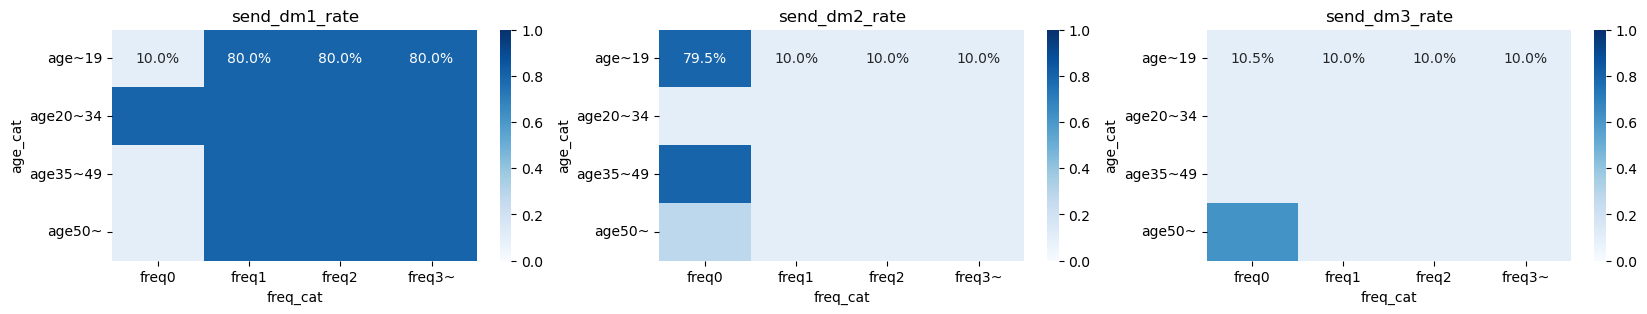

In [253]:
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}_rate')
plt.show()

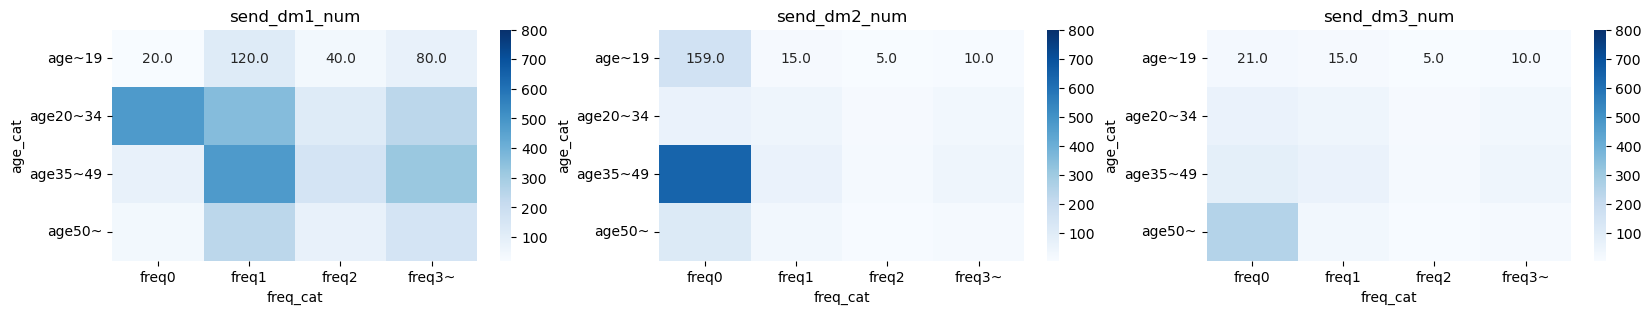

In [254]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat',aggfunc='sum')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}_num')
plt.show()

### モデリング2：セグメント送付モデル

In [255]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)

要件（1） 各会員に対してどのパターンのダイレクトメールを送付するかを決定

- リスト
  - ダイレクトメールのパターンのリスト：$M$(={1,2,3})
    - 1:セールのチラシのみ
    - 2:セールチラシと1000円クーポン
    - 3:セールチラシと2000円クーポン
  - 年齢区分、昨年度来店回数区分によるセグメントのリスト：$S$

- 決定変数
  - セグメント$s(\in S)$ に対するダイレクトメールのパターン$m(\in M)$ の送付率
    - $x_{s,m} \in (0,1)  (s \in S, m \in M)$

In [256]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定
xsm = {}
# ［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})',
        lowBound=0, upBound=1, cat='Continuous')
len(xsm)

48

要件（2） 各会員に対して送付するダイレクトメールはいずれか1 パターン

制約条件
  - 各会員に対して送付するダイレクトメールはいずれか1 パターン
    - $\sum_{m \in M} x_{sm} = 1  (s \in S)$

In [257]:
# （2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1

要件（3） クーポン付与による来客増加数を最大化

- 定数
  - セグメント$s( \in S)$の会員に対してダイレクトメールパターン$m( \in M)$で送付した時の来店率:P_{sm}
    - $P_{sm} \in [0,1] (s \in S, m \in M)$

- 目的変数
  - クーポン付与による来客増加数を最大化
    - $\sum_{s \in S}\sum_{m \in M} N_s (P_{sm} - P_{s1})x_{sm}$

In [258]:
prob_ver_df = prob_df.rename(columns={'prob_dm1': 1,'prob_dm2': 2, 'prob_dm3': 3})\
.melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
Psm = prob_ver_df.set_index(['segment_id','dm'])['prob'].to_dict()

In [259]:
# （3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])

要件（4） 会員の予算消費期待値の合計は100 万円以下

- 定数
  - ダイレクトメールのパターン$m( \in M)$に付与するクーポンの金額:$C_m$
    - $C_m \in {0, 1000, 2000} (m \in M)$

- 制約条件
  - 会員の予算消費期待値の合計は100 万円以下
    - $\sum_{i \in I}\sum_{m \in M} C_{m} P_{im} x_{im} \leq 1000000$

In [260]:
# （4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000

要件（5） 各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10% 以上に送付

- 制約条件
  - 各パターンのダイレクトメールをそれぞれのセグメントに属する会員10% 以上に送付
    - $x_{sm} \geq 0.1 (s \in S, m \in M)$

In [261]:
# （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上に送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= 0.1

## 数理モデル
- リスト
  - ダイレクトメールのパターンのリスト：$M$(={1,2,3})
    - 1:セールのチラシのみ
    - 2:セールチラシと1000円クーポン
    - 3:セールチラシと2000円クーポン
  - 年齢区分、昨年度来店回数区分によるセグメントのリスト：$S$

- 決定変数
  - セグメント$s(\in S)$ に対するダイレクトメールのパターン$m(\in M)$ の送付率
    - $x_{i,m} \in (0,1)  (s \in S, m \in M)$

- 定数
  - セグメント$s( \in S)$の会員に対してダイレクトメールパターン$m( \in M)$で送付した時の来店率:P_{sm}
    - $P_{sm} \in [0,1] (s \in S, m \in M)$
  - ダイレクトメールのパターン$m( \in M)$に付与するクーポンの金額:C_m
    - $C_m \in {0, 1000, 2000} (m \in M)$
  - セグメント$s( \in S)$に属する会員数:N_s
    - $N_s \in N(非負整数) (s \in S)$

- 制約条件
  - 各会員に対して送付するダイレクトメールはいずれか1 パターン
    - $\sum_{m \in M} x_{sm} = 1  (s \in S)$
  - 会員の予算消費期待値の合計は100 万円以下
    - $\sum_{i \in I}\sum_{m \in M} C_{m} P_{im} x_{im} \leq 1000000$
  - 各パターンのダイレクトメールをそれぞれのセグメントに属する会員10% 以上に送付
    - $x_{sm} \geq 0.1 (s \in S, m \in M)$

- 目的変数
  - クーポン付与による来客増加数を最大化
    - $\sum_{s \in S}\sum_{m \in M} N_s (P_{sm} - P_{s1})x_{sm}$

In [262]:
time_start = time.time()
status = problem.solve()
time_stop = time.time()
print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}')
print(f'計算時間:{(time_stop - time_start):.3}(秒)')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/y_suzuki/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/4994b10da2c44b17a119fc6d8a1a0a47-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/4994b10da2c44b17a119fc6d8a1a0a47-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (-48) rows, 32 (-16) columns and 64 (-64) elements
0  Obj 229 Dual inf 981.57657 (32)
6  Obj 326.0951
Optimal - objective value 326.0951
After Postsolve, objective 326.0951, infeasibilities - dual 11.960784 (3), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj 32

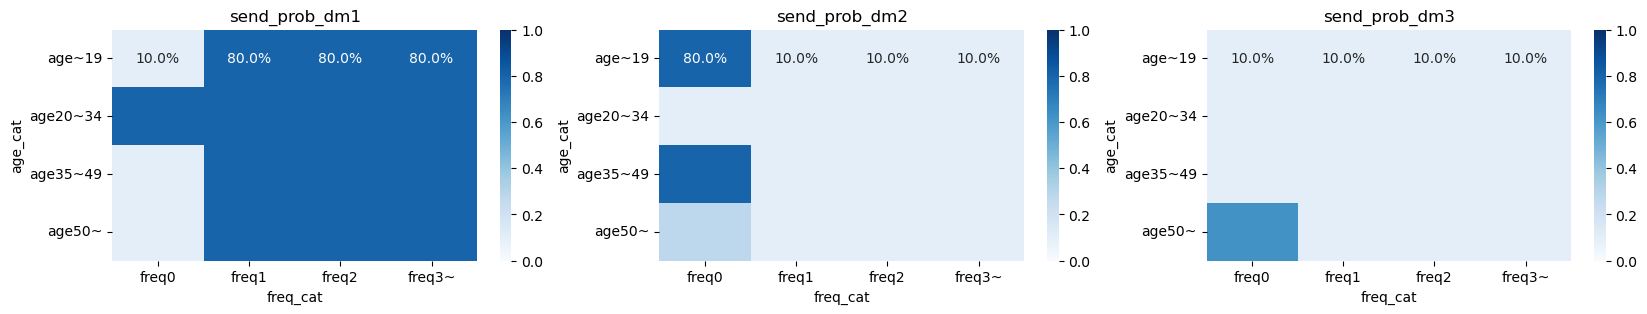

In [263]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

In [264]:
seg_send_df['num_cust'] = seg_send_df['segment_id'].apply(lambda x: Ns[x])
seg_send_df['send_num_dm1'] = seg_send_df['send_prob_dm1']*seg_send_df['num_cust']
seg_send_df['send_num_dm2'] = seg_send_df['send_prob_dm2']*seg_send_df['num_cust']
seg_send_df['send_num_dm3'] = seg_send_df['send_prob_dm3']*seg_send_df['num_cust']
seg_send_df[['segment_id','send_num_dm1','send_num_dm2','send_num_dm3']].head()

,segment_id,send_num_dm1,send_num_dm2,send_num_dm3
0,1,20.0,160.0,20.0
1,2,120.0,15.0,15.0
2,3,40.0,5.0,5.0
3,4,80.0,10.0,10.0
4,5,480.0,60.0,60.0


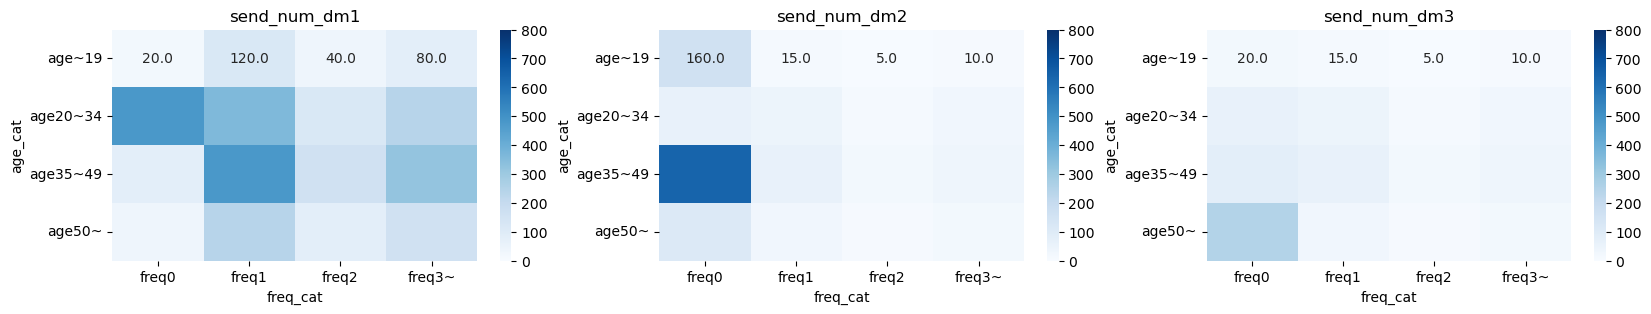

In [265]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_num_dm1','send_num_dm2','send_num_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

## 4.5 結果の評価

### モデリング3：送付率下限値最大化モデル

## 課題整理

> 数理モデル決定事項
- **要件(1):各セグメントへのDMの送付率の下限値と各会員に対してどのDMを送付するかを決定**

> 送付するダイレクトメールの数
- **要件(2):各会員に対して送付するDMはいずれか1パターン**

> 公平性を考慮したキャンペーンでの目的
- **要件(3):各セグメントへのそれぞれのパターンのDMの送付率の下限値を最大化**

> キャンペーン予算
- **要件(4):会員の予算消費期待値の合計は100万円以下**

> 次回以降のクーポンキャンペーンで利用する来客率の収集
- **要件(5):各パターンのDMを設定した送付率の下限値以上を送付**

In [266]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)

要件（1）各セグメントへのDMの送付率の下限値と各会員に対してどのDMを送付するかを決定

- リスト
  - DMのパターンのリスト：$M$(={1,2,3})
    - 1:セールのチラシのみ
    - 2:セールチラシと1000円クーポン
    - 3:セールチラシと2000円クーポン
  - 年齢区分、昨年度来店回数区分によるセグメントのリスト：$S$

- 決定変数
  - セグメント$s(\in S)$ に対するDMのパターン$m(\in M)$ の送付率
    - $x_{i,m} \in (0,1)  (s \in S, m \in M)$
  - 各セグメントへのそれぞれのパターンのDMの送付率の下限値
    - $y \in [0,1]$

In [267]:
# （1）各セグメントへのそれぞれパターンのDMの送付率の下限値と各会員に対してどのDMを送付するかを決定
# 会員に対してどのダイレクトメールを送付するか
xsm = {}
# ［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
# 各セグメントへのそれぞれパターンのDMの送付率の下限値
y = pulp.LpVariable(name='y', lowBound=0, upBound=1, cat='Continuous')

要件 (2）各会員に対して送付するDMはいずれか1パターン

制約条件
  - 各会員に対して送付するダイレクトメールはいずれか1 パターン 
    - $\sum_{m \in M} x_{sm} = 1  (s \in S)$

In [268]:
# （2）各会員に対して送付するDMはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1

要件（3） 各セグメントへのそれぞれのパターンのDMの送付率の下限値を最大化

- 定数
  - セグメント$s( \in S)$の会員に対してダイレクトメールパターン$m( \in M)$で送付した時の来店率:$P_{sm}$
    - $P_{sm} \in [0,1] (s \in S, m \in M)$

- 目的変数
  - 各セグメントへのそれぞれのパターンのDMの送付率の下限値を最大化
    - y

In [269]:
# （3）各セグメントへのそれぞれパターンのDMの送付率の下限値を最大化
problem += y

要件（4）会員の予算消費期待値の合計は100万円以下

- 定数
  - DMのパターン$m( \in M)$に付与するクーポンの金額:$C_m$
    - $C_m \in {0, 1000, 2000} (m \in M)$

- 制約条件
  - 会員の予算消費期待値の合計は100 万円以下
    - $\sum_{s \in S}\sum_{m \in M} C_{m} N_{m} P_{sm} x_{sm} \leq 1000000$

In [270]:
# （4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000

要件（5） 各パターンのDMを設定した送付率の下限値以上に送付

- 制約条件
  - 各パターンのDMを設定した送付率の下限値以上に送付
    - $x_{sm} \geq y (s \in S, m \in M)$

In [271]:
# （5）各パターンのDMを設定した送付率の下限値以上に送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= y

## 数理モデル
- リスト
  - ダイレクトメールのパターンのリスト：$M$(={1,2,3})
    - 1:セールのチラシのみ
    - 2:セールチラシと1000円クーポン
    - 3:セールチラシと2000円クーポン
  - 年齢区分、昨年度来店回数区分によるセグメントのリスト：$S$

- 決定変数
  - セグメント$s(\in S)$ に対するDMのパターン$m(\in M)$ の送付率
    - $x_{i,m} \in (0,1)  (s \in S, m \in M)$
  - 各セグメントへのそれぞれのパターンのDMの送付率の下限値
    - $y \in [0,1]$

- 定数
  - セグメント$s( \in S)$の会員に対してダイレクトメールパターン$m( \in M)$で送付した時の来店率:$P_{sm}$
    - $P_{sm} \in [0,1] (s \in S, m \in M)$
  - ダイレクトメールのパターン$m( \in M)$に付与するクーポンの金額:$C_m$
    - $C_m \in {0, 1000, 2000} (m \in M)$
  - セグメント$s( \in S)$に属する会員数:$N_s$
    - $N_s \in N(非負整数) (s \in S)$

- 制約条件
  - 各会員に対して送付するダイレクトメールはいずれか1 パターン
    - $\sum_{m \in M} x_{sm} = 1  (s \in S)$
  - 会員の予算消費期待値の合計は100 万円以下
    - $\sum_{s \in S}\sum_{m \in M} C_{m} N_{m} P_{sm} x_{sm} \leq 1000000$
  - 各パターンのDMを設定した送付率の下限値以上に送付
    - $x_{sm} \geq y (s \in S, m \in M)$

- 目的変数
  - 各セグメントへのそれぞれのパターンのDMの送付率の下限値を最大化
    - $y$

In [272]:
status = problem.solve()
max_lowerbound = pulp.value(problem.objective)
print(f'ステータス: {pulp.LpStatus[status]}, 目的関数値:{max_lowerbound :.3}')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/y_suzuki/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/64dc53df5ec846afb308645c0e2dbccf-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/64dc53df5ec846afb308645c0e2dbccf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 248 RHS
At line 314 BOUNDS
At line 364 ENDATA
Problem MODEL has 65 rows, 49 columns and 176 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 49 (-16) rows, 33 (-16) columns and 144 (-32) elements
Perturbing problem by 0.001% of 0.62819912 - largest nonzero change 0.00094529304 ( 0.15047666%) - largest zero change 9.6171668e-05
0  Obj -0 Dual inf 0.62725282 (1)
31  Obj 0.13116342 Primal inf 0.17027776 (2)
33  Obj 0.13040049
Optimal -

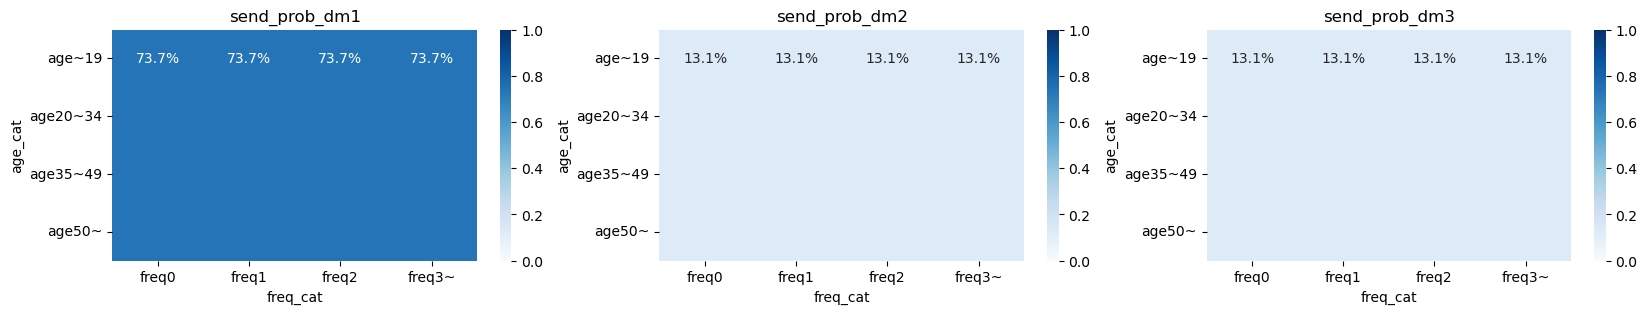

In [273]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M]for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat',index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

In [274]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)
# （1）各会員に対してどのダイレクトメールを送付するかを決定
xsm = {}
# ［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})',lowBound=0, upBound=1, cat='Continuous')
# （2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1
# （3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])
# （4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000
# （5）各パターンのダイレクトメールを設定した送付率の下限値以上に送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= max_lowerbound
status = problem.solve()
print(f'ステータス: {pulp.LpStatus[status]}, 目的関数値:{pulp.value(problem.objective):.4}')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/y_suzuki/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/a290830c621241dcbc0fc513cfcf6713-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/a290830c621241dcbc0fc513cfcf6713-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (-48) rows, 32 (-16) columns and 64 (-64) elements
0  Obj 300.58409 Dual inf 981.57657 (32)
1  Obj 300.58411
Optimal - objective value 300.58411
After Postsolve, objective 300.58411, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 300.5841097 - 1 iterations time 0.002, Presolve 

### 投資対効果の評価

In [275]:
cost_list = []
cpa_list = []
inc_action_list = []

In [276]:
print('ステータス, キャンペーン費用, 来客増加数, CPA')
for cost in range(761850, 3000000, 100000):
    # 数理モデルのインスタンス作成
    problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)
    # （1）各会員に対してどのDM を送付するかを決定
    xsm = {}
    # [0,1]の変数を宣言
    for s in S:
        for m in M:
            xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
    # （2）各会員に対して送付するDMはいずれか1パターン
    for s in S:
        problem += pulp.lpSum(xsm[s,m] for m in M) == 1
    # （3）クーポン付与による来客増加数を最大化
    problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])
    # （4）会員の予算消費期待値の合計はcost円以下
    problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= cost
    # （5）各パターンのDMを設定した送付率の下限値以上に送付
    for s in S:
        for m in M:
            problem += xsm[s,m] >= 0.1
    status = problem.solve()
    cpa = cost/pulp.value(problem.objective)
    inc_action = pulp.value(problem.objective)
    cost_list.append(cost)
    cpa_list.append(cpa)
    inc_action_list.append(inc_action)
    print(f'{pulp.LpStatus[status]}, {cost}, {inc_action :.4}, {cpa :.5}')

ステータス, キャンペーン費用, 来客増加数, CPA
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/y_suzuki/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/765021419f944a819f346248a93947c4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_c/n95nswwd7dq6t2vx_rfc73fm0000gn/T/765021419f944a819f346248a93947c4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-65) rows, 0 (-48) columns and 0 (-128) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 229
After Postsolve, objective 229, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 229 - 0 iterations time 0.002, Presolve 0.0

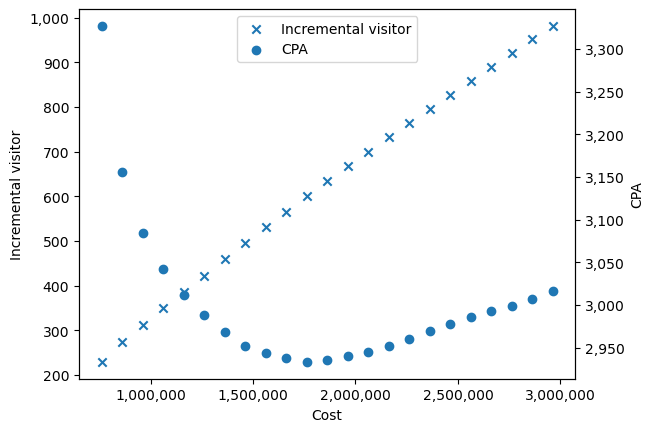

In [277]:
import matplotlib.ticker as ticker
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, inc_action_list, marker='x', label='Incremental visitor')
ax2.scatter(cost_list, cpa_list, label='CPA')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.set_xlabel('Cost')
ax1.set_ylabel('Incremental visitor')
ax2.set_ylabel('CPA')
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc='upper center')
plt.show()